<a href="https://colab.research.google.com/github/Puurun/fastai_code_example/blob/main/Pytorch_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install impyute

In [2]:
!pip install fastai -Uqq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.5 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

In [3]:
gpu = False
device = 'cuda' if gpu else 'cpu'

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import impyute as im
import sys
from impyute.imputation.cs import fast_knn
from sklearn.preprocessing import OrdinalEncoder

In [5]:
df = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [6]:
df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [7]:
dep_var = ['Survived']
cat_var = ['Sex', 'Embarked']
ord_var = ['Pclass']
cont_var = ['Age', 'Fare']
desc_var = ['SibSp', 'Parch']

In [8]:
combine = [df, df_test]
for dataset in combine:
    dataset[cat_var+ord_var] = dataset[cat_var+ord_var].astype('category')
    dataset['Pclass'] = dataset['Pclass'].cat.set_categories([1, 2, 3], ordered=True)

In [9]:
df.dtypes

PassengerId       int64
Survived          int64
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [10]:
null_check = (df.isnull().sum()/ df.isnull().count()).sort_values(ascending=False)
null_check

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

In [11]:
df.info()
print('*'*40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.8+ KB
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       ----------

In [12]:
df.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
df.describe(include=['O'])

,Name,Ticket,Cabin
count,891,891,204
unique,891,681,147
top,"Braund, Mr. Owen Harris",347082,B96 B98
freq,1,7,4


In [14]:
# analyze by pivoting features
features_to_analyze = ['Pclass', 'SibSp', 'Parch', 'Sex']
pivot_analyzation = {
    feature: 
    df[[feature, 'Survived']].groupby(by=[feature], as_index=False).mean().sort_values(by="Survived", ascending=False)
    for feature in features_to_analyze
}

In [15]:
pivot_analyzation['Pclass']

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [16]:
pivot_analyzation['Sex']

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [17]:
pivot_analyzation['SibSp']

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [18]:
pivot_analyzation['Parch']

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


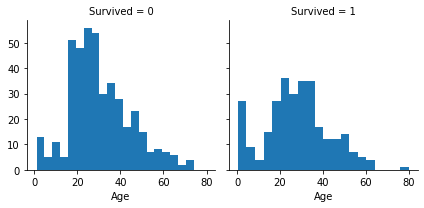

In [19]:
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

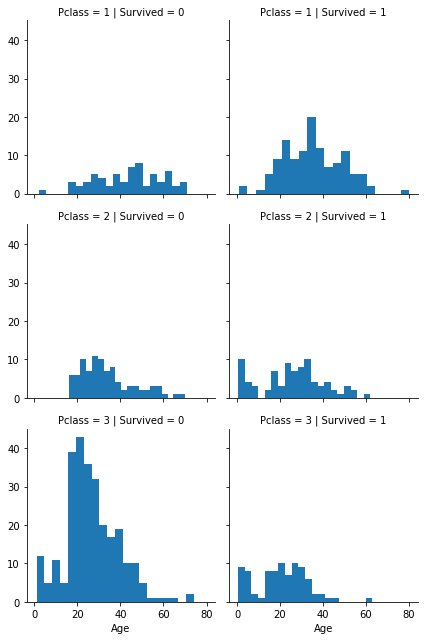

In [20]:
g = sns.FacetGrid(df, col='Survived', row='Pclass')
g.map(plt.hist, 'Age', bins=20)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


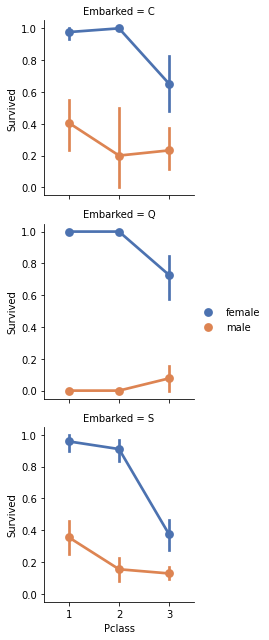

In [21]:
g = sns.FacetGrid(df, row='Embarked')
g.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
g.add_legend()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


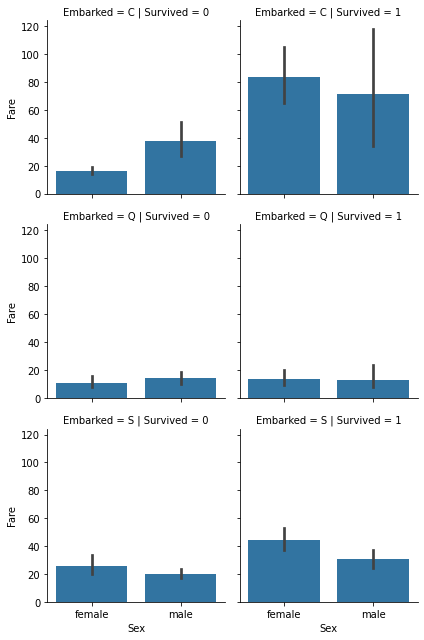

In [22]:
g= sns.FacetGrid(df, row='Embarked', col='Survived')
g.map(sns.barplot, 'Sex', 'Fare')

In [23]:
#Feature Engineering: Cabin->Deck, Ticket->Ticket Frequency, Age-Fare=bin, Surname, Familiy_size

In [24]:
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [25]:
df_test['Age'] = df_test.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [26]:
fareinterval = pd.qcut(df['Fare'], 13, duplicates='drop')
ageinterval = pd.qcut(df['Age'], 10, duplicates='drop')

In [27]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
family_map = {1: 'Alone', 2: 'Small', 3:'Small', 4:'Small', 5:'Medium', 6:'Medium', 7:'Large', 8:'Large', 11:'Large'}
df['FamilyGroup'] = df['FamilySize'].map(family_map)
df_test['FamilyGroup'] = df['FamilySize'].map(family_map)

In [28]:
df.loc[df['Cabin'].isnull(),'Cabin'] = 'M'
df_test.loc[df_test['Cabin'].isnull(), 'Cabin'] = 'M'
df['Deck'] = df['Cabin'].apply(lambda x: x[0])
df_test['Deck'] = df['Cabin'].apply(lambda x:x[0])

In [29]:
df['TicketFrequency'] = np.nan
for uv in df['Ticket'].unique():
    num_ticket = (df['Ticket']==uv).sum()
    df.loc[df['Ticket']==uv,'TicketFrequency'] = num_ticket
    
df_test['TicketFrequency'] = np.nan
for uv in df_test['Ticket'].unique():
    num_ticket = (df_test['Ticket']==uv).sum()
    df_test.loc[df_test['Ticket']==uv,'TicketFrequency'] = num_ticket

In [30]:
ageinterval = pd.arrays.IntervalArray(ageinterval.cat.categories)
fareinterval = pd.arrays.IntervalArray(fareinterval.cat.categories)

In [31]:
ageinterval, fareinterval

(<IntervalArray>
 [(0.419, 16.0], (16.0, 20.0], (20.0, 22.0], (22.0, 25.0], (25.0, 26.0], (26.0, 30.0], (30.0, 34.0], (34.0, 40.0], (40.0, 47.0], (47.0, 80.0]]
 Length: 10, dtype: interval[float64, right],
 <IntervalArray>
 [(-0.001, 7.229], (7.229, 7.75], (7.75, 7.896], (7.896, 8.05], (8.05, 10.5] ... (24.0, 26.55], (26.55, 33.308], (33.308, 55.9], (55.9, 83.158], (83.158, 512.329]]
 Length: 13, dtype: interval[float64, right])

In [32]:
ageinterval.to_tuples()

array([(0.419, 16.0), (16.0, 20.0), (20.0, 22.0), (22.0, 25.0),
       (25.0, 26.0), (26.0, 30.0), (30.0, 34.0), (34.0, 40.0),
       (40.0, 47.0), (47.0, 80.0)], dtype=object)

In [33]:
df['Age'] = df['Age'].apply(lambda x: ageinterval.to_tuples()[ageinterval.contains(x)])
df_test['Age'] = df_test['Age'].apply(lambda x: ageinterval.to_tuples()[ageinterval.contains(x)])

In [34]:
df['Fare'] = df['Fare'].apply(lambda x: fareinterval.to_tuples()[fareinterval.contains(x)])
df_test['Fare'] = df_test['Fare'].apply(lambda x: fareinterval.to_tuples()[fareinterval.contains(x)])

In [35]:
#df = df.drop(['Cabin', 'Ticket'], axis=1)

In [36]:
#df_test = df_test.drop(['Cabin', 'Ticket'], axis=1)

In [37]:
df_test_pi = df_test.copy()['PassengerId']

In [38]:
df_test_pi

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [39]:
combine = [df, df_test]
for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [40]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
df[['Survived', 'Title']].groupby('Title', as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [41]:
df.notnull().mean()

PassengerId        1.000000
Survived           1.000000
Pclass             1.000000
Name               1.000000
Sex                1.000000
Age                1.000000
SibSp              1.000000
Parch              1.000000
Ticket             1.000000
Fare               1.000000
Cabin              1.000000
Embarked           0.997755
FamilySize         1.000000
FamilyGroup        1.000000
Deck               1.000000
TicketFrequency    1.000000
Title              1.000000
dtype: float64

In [42]:
for dataset in combine:
    dataset.drop(['Name', 'PassengerId', 'Cabin'], axis=1, inplace=True)

In [43]:
def categorify(df, df_test, dep_var='Survived', exclude=[]):
    df = df.copy()
    df_test = df_test.copy()
    new = pd.concat([df, df_test]).drop([dep_var]+exclude, axis=1)
    dicts = {str(col): {k[1]:k[0] for k in enumerate(new[col].unique())} for col in new}
    for key, val in dicts.items():
        df[key] = df[key].map(val).astype(float)
        df_test[key] = df_test[key].map(val).astype(float)
    return df, df_test

In [44]:
combined = [df, df_test]
for dataset in combined:
    dataset['Age'] = dataset['Age'].map(str)
    dataset['Fare'] = dataset['Fare'].map(str)


In [45]:
df['Age'].unique()

array(['[(20.0, 22.0)]', '[(34.0, 40.0)]', '[(25.0, 26.0)]',
       '[(22.0, 25.0)]', '[(47.0, 80.0)]', '[(0.419, 16.0)]',
       '[(26.0, 30.0)]', '[(16.0, 20.0)]', '[(30.0, 34.0)]',
       '[(40.0, 47.0)]'], dtype=object)

In [46]:
"""def categorify(df, df_test):
    df = df.copy()
    df_test = df_test.copy()
    new = pd.concat([df, df_test])
    sexdict = {k[1]: k[0] for k in enumerate(new['Sex'].unique())}
    embdict = {k[1]: k[0] for k in enumerate(new['Embarked'].unique())}
    titdict = {k[1]: k[0] for k in enumerate(new['Title'].unique())}
    pardict = {k[1]: k[0] for k in enumerate(new['Parch'].unique())}
    pcldict = {k[1]: k[0] for k in enumerate(new['Pclass'].astype(int).unique())}
    sibdict = {k[1]: k[0] for k in enumerate(new['SibSp'].astype(int).unique())}
    dicts = {'Sex': sexdict, 'Embarked': embdict, 'Title': titdict, 'Parch': pardict, 'Pclass': pcldict, 'SibSp':sibdict}
    for key, val in dicts.items():
        df[key] = df[key].map(val).astype(float)
        df_test[key] = df_test[key].map(val).astype(float)
    return df, df_test"""

"def categorify(df, df_test):\n    df = df.copy()\n    df_test = df_test.copy()\n    new = pd.concat([df, df_test])\n    sexdict = {k[1]: k[0] for k in enumerate(new['Sex'].unique())}\n    embdict = {k[1]: k[0] for k in enumerate(new['Embarked'].unique())}\n    titdict = {k[1]: k[0] for k in enumerate(new['Title'].unique())}\n    pardict = {k[1]: k[0] for k in enumerate(new['Parch'].unique())}\n    pcldict = {k[1]: k[0] for k in enumerate(new['Pclass'].astype(int).unique())}\n    sibdict = {k[1]: k[0] for k in enumerate(new['SibSp'].astype(int).unique())}\n    dicts = {'Sex': sexdict, 'Embarked': embdict, 'Title': titdict, 'Parch': pardict, 'Pclass': pcldict, 'SibSp':sibdict}\n    for key, val in dicts.items():\n        df[key] = df[key].map(val).astype(float)\n        df_test[key] = df_test[key].map(val).astype(float)\n    return df, df_test"

In [47]:
combine = [df, df_test]
df, df_test = categorify(df, df_test, exclude=[])

In [48]:
df_test

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,FamilyGroup,Deck,TicketFrequency,Title
0,0.0,0.0,1.0,1.0,0.0,681.0,9.0,2.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,9.0,0.0,0.0,682.0,10.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2.0,0.0,4.0,1.0,0.0,683.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,6.0,1.0,0.0,684.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,405.0,6.0,0.0,3.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,0.0,3.0,1.0,0.0,926.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
414,1.0,1.0,1.0,1.0,0.0,273.0,11.0,1.0,1.0,1.0,0.0,0.0,5.0
415,0.0,0.0,1.0,1.0,0.0,927.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
416,0.0,0.0,3.0,1.0,0.0,928.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0


In [49]:
from sklearn.impute import KNNImputer

In [50]:
imp = KNNImputer()

In [51]:
df = pd.DataFrame(imp.fit_transform(df.values), columns=df.columns)
df_test = pd.DataFrame(imp.fit_transform(df_test.values), columns=df_test.columns)

In [52]:
df['Embarked'] = df['Embarked'].astype(int)
df_test['Embarked'] = df_test['Embarked'].astype(int)

In [53]:
for i in df:
    print(f'key: {i}, unique: {df[i].nunique()}')
print('-'*10)
for i in df_test:
    print(f'key: {i}, unique: {df_test[i].nunique()}') 

key: Survived, unique: 2
key: Pclass, unique: 3
key: Sex, unique: 2
key: Age, unique: 10
key: SibSp, unique: 7
key: Parch, unique: 7
key: Ticket, unique: 681
key: Fare, unique: 14
key: Embarked, unique: 3
key: FamilySize, unique: 9
key: FamilyGroup, unique: 4
key: Deck, unique: 9
key: TicketFrequency, unique: 7
key: Title, unique: 5
----------
key: Pclass, unique: 3
key: Sex, unique: 2
key: Age, unique: 11
key: SibSp, unique: 7
key: Parch, unique: 8
key: Ticket, unique: 363
key: Fare, unique: 14
key: Embarked, unique: 3
key: FamilySize, unique: 9
key: FamilyGroup, unique: 4
key: Deck, unique: 9
key: TicketFrequency, unique: 5
key: Title, unique: 6


In [54]:
combined = df, df_test

In [55]:
for dataset in combined:
    dataset = dataset.drop(['SibSp', 'Parch', 'Ticket'], axis=1)

In [56]:
df_test

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,FamilyGroup,Deck,TicketFrequency,Title
0,0.0,0.0,1.0,1.0,0.0,681.0,9.0,2,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,9.0,0.0,0.0,682.0,10.0,0,0.0,0.0,1.0,0.0,1.0
2,2.0,0.0,4.0,1.0,0.0,683.0,4.0,2,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,6.0,1.0,0.0,684.0,4.0,0,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,405.0,6.0,0,3.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,0.0,3.0,1.0,0.0,926.0,2.0,0,1.0,1.0,0.0,0.0,0.0
414,1.0,1.0,1.0,1.0,0.0,273.0,11.0,1,1.0,1.0,0.0,0.0,5.0
415,0.0,0.0,1.0,1.0,0.0,927.0,0.0,0,1.0,1.0,0.0,0.0,0.0
416,0.0,0.0,3.0,1.0,0.0,928.0,2.0,0,1.0,0.0,0.0,0.0,0.0


In [57]:
from torch.nn import *
from torch import nn

In [58]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from fastai.tabular.all import *

In [59]:
cat = df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title']]
cont = df[['Age', 'Fare']]
cat.join(cont).iloc[0]
dv = df['Survived']
dv.iloc[0]
df.index[3]

3

In [60]:
def randomSplit(df, valid_ratio=0.2, random_state=None):
    split_idx = int(len(df.index)*(valid_ratio))
    shuffled_df = df.sample(frac=1, random_state=random_state)
    return shuffled_df.iloc[split_idx:], shuffled_df[:split_idx]

In [61]:
class TitanicDataset(Dataset):
    def __init__(self, df, is_test=False):
        self.is_test = is_test
        self.df = df.copy()
        self.cat = self.df[['Pclass', 'Sex', 'Embarked', 'Title', 'FamilyGroup', 'Deck' ,'Age', 'Fare', 'TicketFrequency', 'FamilySize']].astype(int)
        self.cont = self.df[[]]
        self.res_df = self.cat.join(self.cont)
        if not(is_test):
            self.dep_var = self.df['Survived'].astype(int)
        self.columns = self.res_df.columns
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        if self.is_test:
            return self.res_df.iloc[idx].values
        else:
            return self.res_df.iloc[idx].values, self.dep_var.iloc[idx]

In [62]:
train_df, valid_df = randomSplit(df)

In [63]:
full_td = TitanicDataset(df)
td = TitanicDataset(train_df)
valid_td = TitanicDataset(valid_df)
test_ds = TitanicDataset(df_test, is_test=True)
in_columns = td.columns
cat_columns = td.cat.columns
cat_n = len(td.cat.columns)
cont_n = len(td.cont.columns)
td.res_df.sort_values('TicketFrequency')

,Pclass,Sex,Embarked,Title,FamilyGroup,Deck,Age,Fare,TicketFrequency,FamilySize
287,0,0,0,0,1,0,0,9,0,1
522,0,0,1,0,1,0,3,10,0,1
134,2,0,0,0,1,0,3,6,0,1
589,0,0,0,0,1,0,3,2,0,1
593,0,1,2,2,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
686,0,0,0,0,2,0,5,3,6,5
167,0,1,0,1,2,0,9,7,6,5
824,0,0,0,3,2,0,5,3,6,5
480,0,0,0,3,3,0,5,3,6,7


In [64]:
dl = DataLoader(td, batch_size=64)
valid_dl = DataLoader(valid_td, batch_size=64)

In [65]:
iterdl = iter(dl)

In [66]:
next(iterdl)[0][:, 8]

tensor([1, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 3, 0, 1, 1, 3,
        1, 0, 2, 2, 0, 0, 0, 0, 0, 6, 0, 3, 1, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 6, 1, 6, 6, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 0])

In [67]:
np.array(test_ds).shape

(418, 10)

In [68]:
voc = []
for s in cat_columns:
    vn = pd.concat([td.cat[s], valid_td.cat[s], test_ds.cat[s]])
    vn = vn.astype(int).nunique()
    voc.append([vn, vn])


In [69]:
voc

[[3, 3],
 [2, 2],
 [3, 3],
 [6, 6],
 [4, 4],
 [9, 9],
 [11, 11],
 [14, 14],
 [7, 7],
 [9, 9]]

In [70]:
class TabModel(Module):
    def __init__(self, emb_sz, cat_n, cont_n, layers):
        super(TabModel, self).__init__()
        self.cat_n = cat_n
        self.cont_n = cont_n
        self.embeddings = nn.ModuleList(nn.Embedding(ni, nf) for ni, nf in emb_sz)
        cat_len = sum([x for _, x in emb_sz])
        self.emb_drop = nn.Dropout(0.2)
        self.linear_drop = nn.Dropout(0.5)
        model = []
        model.append(nn.BatchNorm1d(cat_len+cont_n))
        model.append(self.linear_drop)
        model.append(nn.Linear(cat_len+cont_n, layers[0]))
        model.append(nn.Mish())
        for i in range(len(layers)-2):
            model.append(nn.BatchNorm1d(layers[i]))
            model.append(self.linear_drop)
            model.append(nn.Linear(layers[i], layers[i+1]))
            model.append(nn.Mish())
        self.linear = nn.Sequential(*model)
        self.final_layer = nn.Linear(layers[-2], layers[-1])
        
    def forward(self, x):
        emb = []
        for i in range(self.cat_n):
            emb.append(self.embeddings[i](x[:,i].int()))
        for i in range(self.cat_n, self.cat_n+self.cont_n):
            emb.append(x[:,i].unsqueeze(1))
        input = torch.cat(emb, dim=1).float()
        res = self.linear(input)
        res = self.final_layer(res)
        return res


In [71]:
tabmodel = TabModel(voc, cat_n, cont_n, (400, 300, 200, 100, 2)).to(device)

In [72]:
print(tabmodel)

TabModel(
  (embeddings): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(2, 2)
    (2): Embedding(3, 3)
    (3): Embedding(6, 6)
    (4): Embedding(4, 4)
    (5): Embedding(9, 9)
    (6): Embedding(11, 11)
    (7): Embedding(14, 14)
    (8): Embedding(7, 7)
    (9): Embedding(9, 9)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (linear_drop): Dropout(p=0.5, inplace=False)
  (linear): Sequential(
    (0): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=68, out_features=400, bias=True)
    (3): Mish()
    (4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=400, out_features=300, bias=True)
    (7): Mish()
    (8): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=300, out_features=2

In [73]:
dls = dl, valid_dl

In [74]:
def train(dl, model, loss_fn, optim):
    size = len(dl.dataset)
    losses = []
    for batch, (X, y) in enumerate(dl):
        # prediction, loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())
    
    print(f'loss: {np.array(losses).mean()}')


In [75]:
def valid(valid_dl, model, loss_fn):
    accuracy = []
    losses = []
    with torch.no_grad():
        for batch, (X, y) in enumerate(valid_dl):
            #p rediction, loss
            pred = model(X)
            loss = loss_fn(pred, y)
            # metric
            accuracy.append((pred.argmax(1)==y).float().flatten().mean())
            losses.append(loss.item())
    print(f'valid -- accuracy: {np.array(accuracy).mean()}, loss: {np.array(losses).mean()}')

In [76]:
def epoch(n, dls, model:Module, loss_fn, lr=1e-3):
    train_dl, valid_dl = dls
    
    for i in range(n):
        # train
        model.train()
        train(train_dl, model, loss_fn, torch.optim.Adam(model.parameters(), lr= lr))
        #validate
        model.eval()
        valid(valid_dl, model, loss_fn)

In [77]:
epoch(8, dls, tabmodel, CrossEntropyLoss(), lr=5e-4)

loss: 0.6497604697942734
valid -- accuracy: 0.7102083563804626, loss: 0.6194993654886881
loss: 0.5492421984672546
valid -- accuracy: 0.7593750357627869, loss: 0.5248653292655945
loss: 0.5061957662304243
valid -- accuracy: 0.7697916626930237, loss: 0.4869846999645233
loss: 0.5004060144225756
valid -- accuracy: 0.7764583230018616, loss: 0.4876803457736969
loss: 0.4999237557252248
valid -- accuracy: 0.777916669845581, loss: 0.4865359465281169
loss: 0.4557991847395897
valid -- accuracy: 0.7712500095367432, loss: 0.4824926753838857
loss: 0.4513949453830719
valid -- accuracy: 0.7920833230018616, loss: 0.4702235758304596
loss: 0.4690590724349022
valid -- accuracy: 0.7816666960716248, loss: 0.46867676575978595


In [78]:
def predictWhole(data, model):
    model.eval()
    pred = model(data)
    return pred.argmax(1)

In [79]:
test_ds_raw = torch.Tensor(np.array(test_ds))

In [80]:
test_ds_raw.shape

torch.Size([418, 10])

In [81]:
preds = predictWhole(test_ds_raw, tabmodel)
len(preds)

418

In [82]:
result = pd.DataFrame({'PassengerId': df_test_pi, 'Survived': preds})

In [83]:
result.to_csv('submission.csv', index=False)

In [84]:
def randSplit(l, valid_ratio=0.2):
    idxs = np.arange(l)
    np.random.shuffle(idxs)
    cut = int(l*valid_ratio)
    return idxs[:cut], idxs[cut:]

In [85]:
dls = DataLoaders(dl, valid_dl)

In [86]:
voc = []
for s in cat_columns:
    vn = pd.concat([td.cat[s], valid_td.cat[s], test_ds.cat[s]])
    vn = vn.astype(int).nunique()
    voc.append([vn, round(1.6 * vn**0.56)])
voc

[[3, 3],
 [2, 2],
 [3, 3],
 [6, 4],
 [4, 3],
 [9, 5],
 [11, 6],
 [14, 7],
 [7, 5],
 [9, 5]]

In [87]:
tabmodel = TabModel(voc, cat_n, cont_n, (20, 10, 2)).to(device)
print(tabmodel)

TabModel(
  (embeddings): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(2, 2)
    (2): Embedding(3, 3)
    (3): Embedding(6, 4)
    (4): Embedding(4, 3)
    (5): Embedding(9, 5)
    (6): Embedding(11, 6)
    (7): Embedding(14, 7)
    (8): Embedding(7, 5)
    (9): Embedding(9, 5)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (linear_drop): Dropout(p=0.5, inplace=False)
  (linear): Sequential(
    (0): BatchNorm1d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=43, out_features=20, bias=True)
    (3): Mish()
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): Mish()
  )
  (final_layer): Linear(in_features=10, out_features=2, bias=True)
)


In [88]:
learn = Learner(dls, tabmodel, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.0030199517495930195)

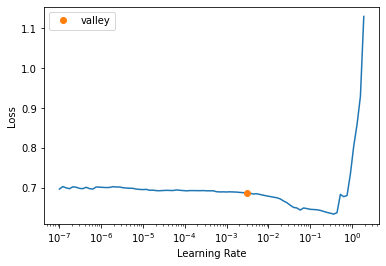

In [89]:
learn.lr_find()

In [90]:
learn.fit_one_cycle(5, 6e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.683273,0.650167,0.623595,00:00
1,0.640082,0.575654,0.724719,00:00
2,0.595520,0.521973,0.735955,00:00
3,0.565294,0.509915,0.752809,00:00
4,0.539175,0.509180,0.758427,00:00


In [91]:
preds = predictWhole(test_ds_raw, learn.model)

In [92]:
result = pd.DataFrame({'PassengerId': df_test_pi, 'Survived': preds})
result.to_csv('submission.csv', index=False)

In [93]:
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [94]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [95]:
X = full_td[:][0]
y = full_td[:][1]

In [96]:
clf = HistGradientBoostingClassifier(max_iter=1100, max_leaf_nodes=31, max_depth=7, min_samples_leaf=5).fit(X, y)

In [97]:
#cross_val_score(clf, X, y, cv=5)

In [98]:
preds = clf.predict(test_ds_raw)

In [99]:
result = pd.DataFrame({'PassengerId': df_test_pi, 'Survived': preds})
result.to_csv('submission.csv', index=False)

In [100]:
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [101]:
df = df.astype(int).drop('Ticket', axis=1)
df_test = df_test.astype(int).drop('Ticket', axis=1)

In [102]:
cat_var = df_test.columns
combined = [df, df_test]
for dataset in combined:
    for key in cat_var:
        dataset[key] = dataset[key].astype('category')
    

In [103]:
x1 = df.drop('Survived', axis=1)
x1['name'] = 'train'

In [104]:
x2 = df_test.copy()
x2['name'] = 'test'

In [105]:
xs = pd.concat([x1, x2])

In [106]:
X = pd.get_dummies(xs)
train_X = X.loc[xs['name']=='train']
test_X = X.loc[xs['name']=='test']
y = df['Survived']

In [107]:
X

,Age,Parch,TicketFrequency,Title,Pclass_0,Pclass_1,Pclass_2,Sex_0,Sex_1,SibSp_0,...,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,name_test,name_train
0,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,1,0,0,1,1,...,1,0,0,0,0,0,0,0,0,1
2,2,0,0,2,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,1,1,0,1,0,0,1,1,...,1,0,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
414,1,0,0,5,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
415,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
416,3,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [108]:
train_X = train_X.drop(['name_test', 'name_train'], axis=1)
test_X = test_X.drop(['name_test', 'name_train'], axis=1)

In [109]:
clf = HistGradientBoostingClassifier(max_iter=15, max_leaf_nodes=31, max_depth=7, min_samples_leaf=5).fit(train_X, y)

In [110]:
cross_val_score(clf, train_X, y, cv=5)

array([0.82681564, 0.80898876, 0.85955056, 0.81460674, 0.83146067])

In [111]:
rf = RandomForestClassifier(n_estimators=1400, max_depth=7, min_samples_leaf = 7, oob_score=True)

In [112]:
rf.fit(train_X,y)

RandomForestClassifier(max_depth=7, min_samples_leaf=7, n_estimators=1400,
                       oob_score=True)

In [113]:
rf.oob_score_

0.8271604938271605

In [114]:
cross_val_score(rf, train_X, y, cv=5)

array([0.83240223, 0.82022472, 0.8258427 , 0.80898876, 0.8258427 ])

In [115]:
preds = clf.predict(test_X)
result = pd.DataFrame({'PassengerId': df_test_pi, 'Survived': preds})
result.to_csv('submission_hist.csv', index=False)
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [116]:
preds = rf.predict(test_X)
result = pd.DataFrame({'PassengerId': df_test_pi, 'Survived': preds})
result.to_csv('submission_rf.csv', index=False)
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
